In [1]:
import os
import numpy as np
import cv2
from PIL import Image

import seaborn as sns
from matplotlib import pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import roc_curve, auc, recall_score, precision_score
from sklearn.metrics import precision_recall_curve
import tensorflow as tf

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
directory = os.path.join(path, 'brain_tumor_dataset')

In [5]:
class_names= ['no', 'yes']
batch_size = 32
image_size = (224, 224)

In [6]:
# Chargement des images à partir du répertoire
brain_tumor = tf.keras.utils.image_dataset_from_directory(
    directory=directory,
    label_mode='binary',
    class_names=class_names,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_size
)

Found 253 files belonging to 2 classes.


In [7]:
# Normalisation des valeurs des pixels
brain_tumor = brain_tumor.map(lambda x, y: (x / 255.0, y)) # normalisation
batch = brain_tumor.as_numpy_iterator().next()
batch[0].min(), batch[0].max()

(0.0, 1.0)

In [8]:
labeled_data = brain_tumor.map(lambda x, y: (x, y))
images_labels = list(labeled_data.unbatch())

In [9]:
# Division de l'ensemble de données en ensembles d'entraînement, de validation et de test
train_data, test_data, train_labels, test_labels = train_test_split(
    np.array([image for image, label in images_labels]),
    np.array([label for image, label in images_labels]),
    test_size=0.2,
    random_state=42
)

train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, 
    train_labels, 
    test_size=0.1, 
    random_state=42
)

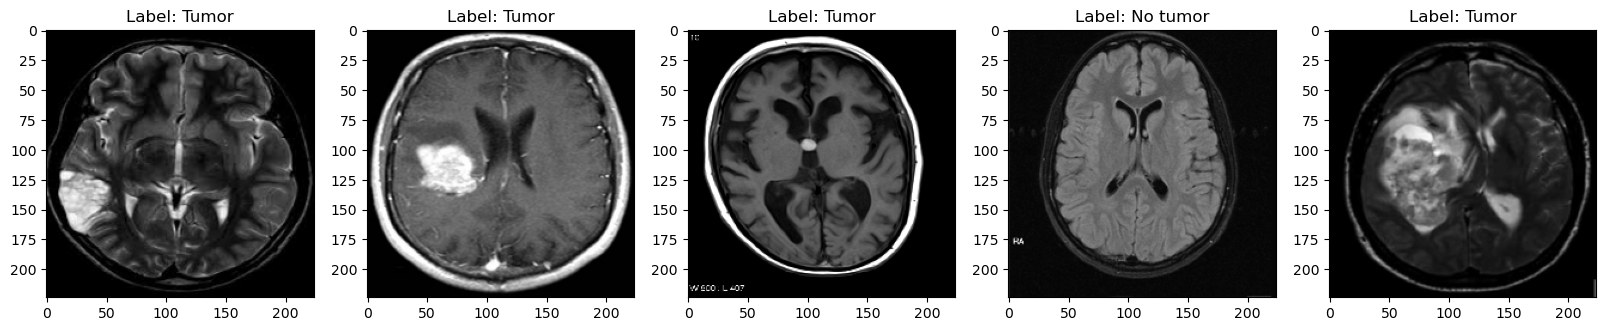

In [10]:
# Visualisation de 5 images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,20))
for i in range(5):
    axes_flat = axes.flatten()
    axes_flat[i].imshow(train_data[i], cmap=plt.cm.gray)
    axes_flat[i].set_title('Label: %s' % ('Tumor' if train_labels[i] else 'No tumor'))

# **Image Data Generator**

In [11]:
# Définition des transformations à appliquer
data_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

# Ajustement du générateur aux données
data_generator.fit(train_data)

# Génère des données supplémentaires
augmented_data = data_generator.flow(
    train_data, train_labels.reshape(-1, 1),
    batch_size=batch_size,
    shuffle=True,
)

# **Convolutional Neural Network**

In [12]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 

    plt.figure(figsize=(12, 8))
    fig, axs = plt.subplots(1, 2, figsize=(20,5))
    
    # Loss
    for l in loss_list:
        axs[0].plot(history.history[l], label='Train loss (' + str(str(format(history.history[l][-1], '.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(history.history[l], label='Validation loss (' + str(str(format(history.history[l][-1], '.5f'))+')'))
    
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    
    # Accuracy
    for l in acc_list:
        axs[1].plot(history.history[l], label='Train accuracy (' + str(format(history.history[l][-1], '.5f'))+')')
    for l in val_acc_list:
        axs[1].plot(history.history[l], label='Validation accuracy (' + str(format(history.history[l][-1], '.5f'))+')')
    
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    
    plt.show()

In [13]:
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr / 2
    else:
        return lr

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Lambda
from tensorflow.keras.models import Model

# Chargement du modèle VGG16 sans les couches fully-connected
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Ajouter une couche de conversion pour les images en noir et blanc
inputs = Input(shape=(224, 224, 1))
rgb_inputs = Lambda(lambda x: tf.concat([x, x, x], axis=-1))(inputs)

# Geler les poids des couches pré-entraînées
for layer in vgg16.layers:
    layer.trainable = False

# Ajouter votre propre architecture de classification
x = vgg16(rgb_inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Créer le modèle final
model = Model(inputs=inputs, outputs=outputs)

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 2s 0us/step


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

Epoch 1/1000
6/6 [==============================] - 13s 610ms/step - loss: 0.6876 - accuracy: 0.5359 - val_loss: 0.6479 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 2/1000
6/6 [==============================] - 1s 136ms/step - loss: 0.7691 - accuracy: 0.5304 - val_loss: 0.6354 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 3/1000
6/6 [==============================] - 1s 134ms/step - loss: 0.6621 - accuracy: 0.6409 - val_loss: 0.6246 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 4/1000
6/6 [==============================] - 1s 133ms/step - loss: 0.6908 - accuracy: 0.5746 - val_loss: 0.6159 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 5/1000
6/6 [==============================] - 1s 136ms/step - loss: 0.6690 - accuracy: 0.6133 - val_loss: 0.6084 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 6/1000
6/6 [==============================] - 1s 134ms/step - loss: 0.6763 - accuracy: 0.5912 - val_loss: 0.5884 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/1000
6/6 [==============================] - 1s 134ms/step - l

<Figure size 1200x800 with 0 Axes>

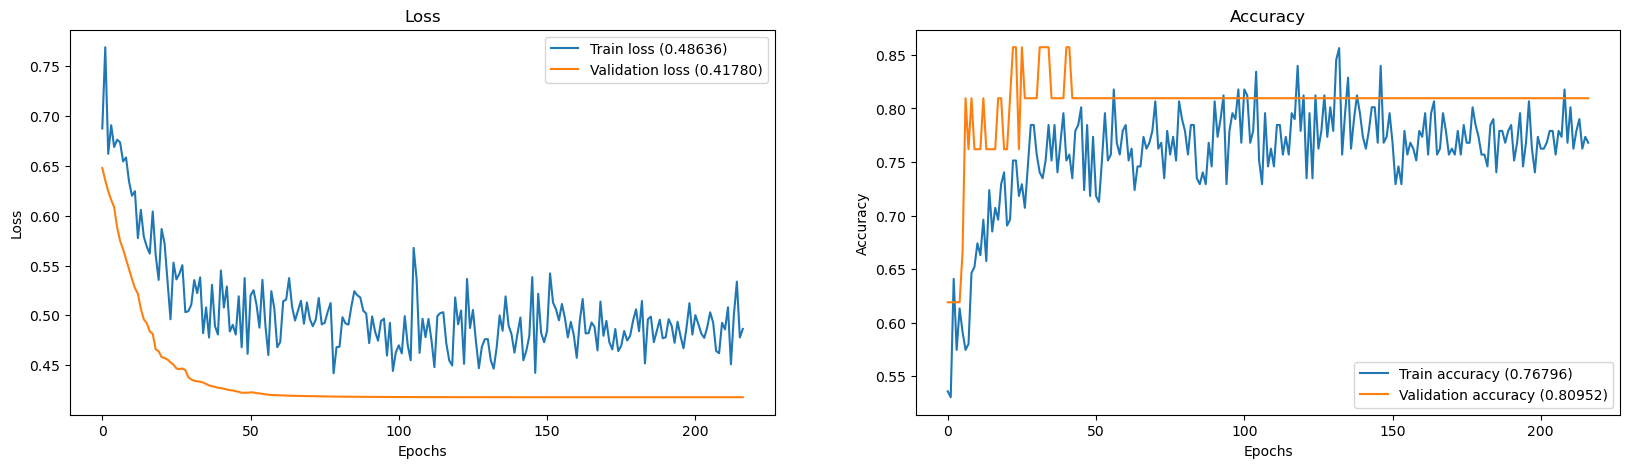

In [16]:
es = EarlyStopping(monitor='val_loss', patience=20)
lr_schedule = LearningRateScheduler(lr_scheduler)
history = model.fit(augmented_data, epochs=1000, validation_data=(val_data, val_labels), callbacks=[es, lr_schedule])
plot_history(history)

# **Model Evaluation**

In [17]:
def evaluate_model(model, test_data, test_labels):
    # Évaluation du modèle sur les données de test
    model.evaluate(test_data, test_labels)
    
    # Prédiction des classes pour les données de test
    y_pred = model.predict(test_data)
    y_pred_classes = np.round(y_pred)

    # Calcul de la matrice de confusion
    cm = confusion_matrix(test_labels, y_pred_classes)

    # Rapport de classification
    clr = classification_report(test_labels, y_pred_classes)

    # Affichage de la matrice de confusion
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)

2/2 [==============================] - 0s 58ms/step


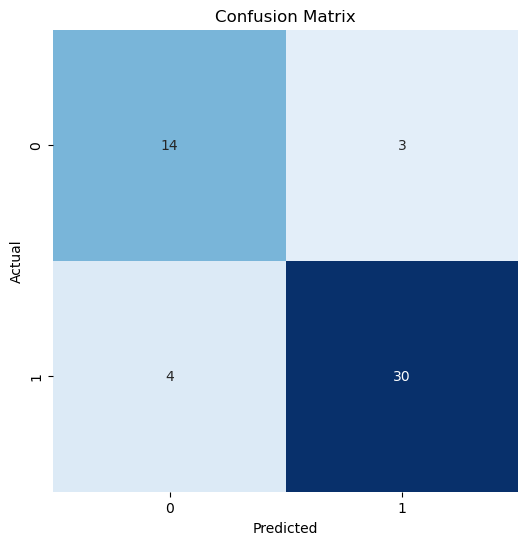

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.78      0.82      0.80        17
         1.0       0.91      0.88      0.90        34

    accuracy                           0.86        51
   macro avg       0.84      0.85      0.85        51
weighted avg       0.87      0.86      0.86        51



In [18]:
evaluate_model(model, test_data, test_labels)

In [19]:
def plot_roc_curve(model, test_data, test_labels):
    # Prédiction des classes pour les données de test
    y_pred = model.predict(test_data)
    # Calcul du taux de faux positifs (FPR), du taux de vrais positifs (TPR) et des seuils
    fpr, tpr, thresholds = roc_curve(test_labels, y_pred)

    # Calcul de l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Trace la courbe ROC
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

2/2 [==============================] - 0s 59ms/step


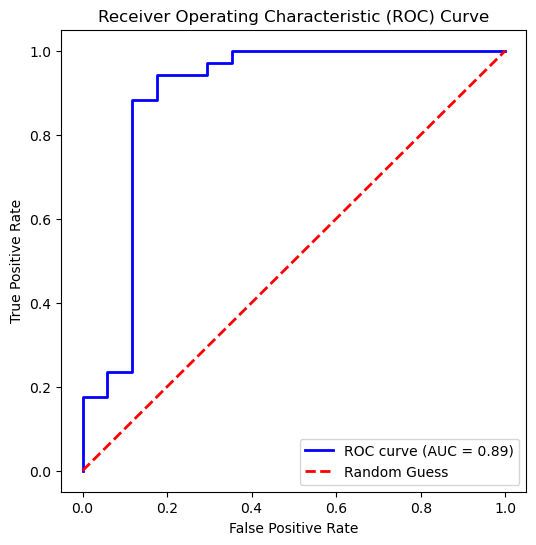

In [20]:
plot_roc_curve(model, test_data, test_labels)

In [21]:
def scores(model, test_data, test_labels):
    # Prédiction des classes pour les données de test
    y_pred = model.predict(test_data)
    y_pred_classes = np.round(y_pred)

    # Calcul des scores avec arrondi à 2 décimales
    f1 = round(f1_score(test_labels, y_pred_classes), 2)
    recall = round(recall_score(test_labels, y_pred_classes), 2)
    precision = round(precision_score(test_labels, y_pred_classes), 2)

    # Affichage des scores
    print("F1 score:", f1)
    print("Recall score:", recall)
    print("Precision score:", precision)

In [22]:
scores(model, test_data, test_labels)

2/2 [==============================] - 0s 58ms/step
F1 score: 0.9
Recall score: 0.88
Precision score: 0.91


# **RandomSearch Tuner**

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

In [24]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(filters=hp.Int('filters_1', min_value=16, max_value=128, step=16),
                            kernel_size=hp.Choice('kernel_1', values=[3, 5]),
                            activation='relu',
                            input_shape=(224, 224, 1)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.3, step=0.1)))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [25]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='my_dir',
    project_name='brain_tumor')

# Recherche des hyperparamètres optimaux
tuner.search(augmented_data, epochs=10, validation_data=(val_data, val_labels), callbacks=[es, lr_schedule])
# Affichage des résultats
tuner.results_summary()

Trial 5 Complete [00h 00m 12s]
val_accuracy: 0.7142857313156128

Best val_accuracy So Far: 0.9047619104385376
Total elapsed time: 00h 01m 47s
Results summary
Results in my_dir/brain_tumor
Showing 10 best trials
Trial summary
Hyperparameters:
filters_1: 32
kernel_1: 3
units: 192
dropout: 0.1
learning_rate: 0.001
Score: 0.9047619104385376
Trial summary
Hyperparameters:
filters_1: 80
kernel_1: 5
units: 128
dropout: 0.30000000000000004
learning_rate: 0.0001
Score: 0.8095238208770752
Trial summary
Hyperparameters:
filters_1: 112
kernel_1: 3
units: 32
dropout: 0.1
learning_rate: 0.0001
Score: 0.8095238208770752
Trial summary
Hyperparameters:
filters_1: 32
kernel_1: 5
units: 32
dropout: 0.30000000000000004
learning_rate: 0.01
Score: 0.7142857313156128
Trial summary
Hyperparameters:
filters_1: 48
kernel_1: 3
units: 32
dropout: 0.30000000000000004
learning_rate: 0.0001
Score: 0.6666666865348816


# **Model Evaluation**

In [26]:
# Récupération du meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

In [27]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 192)               75700416  
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 193       
                                                        

2/2 [==============================] - 0s 5ms/step


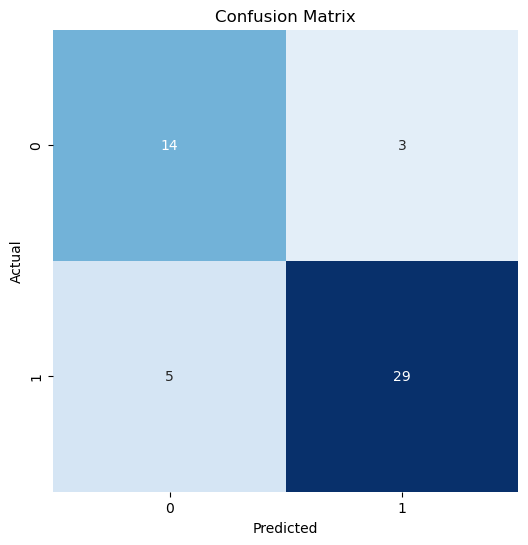

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.74      0.82      0.78        17
         1.0       0.91      0.85      0.88        34

    accuracy                           0.84        51
   macro avg       0.82      0.84      0.83        51
weighted avg       0.85      0.84      0.85        51



In [28]:
evaluate_model(best_model, test_data, test_labels)

2/2 [==============================] - 0s 5ms/step


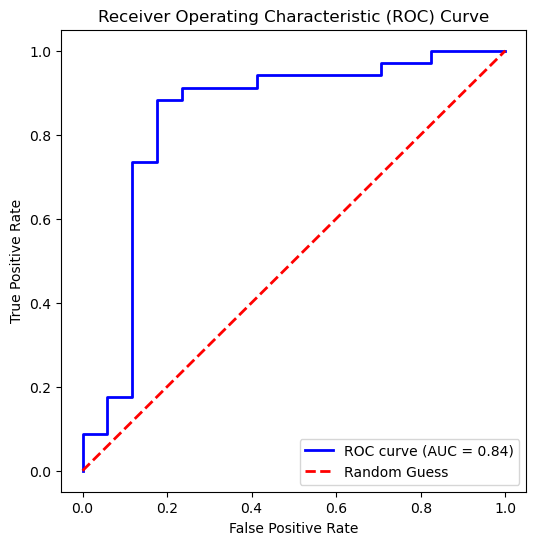

In [29]:
plot_roc_curve(best_model, test_data, test_labels)

In [30]:
scores(best_model, test_data, test_labels)

2/2 [==============================] - 0s 6ms/step
F1 score: 0.88
Recall score: 0.85
Precision score: 0.91
